In [72]:
import pandas
import numpy as np
import time
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Now let's scale up the number of lines to see how good we get our AI

In [73]:
READ_LINES = 20000
best_features = ['AddressOfEntryPoint', 'MajorLinkerVersion', 'NumberOfSections', 'PointerToRawData', 'SizeOfCode', 'SizeOfImage', 'SizeOfInitializedData',
                 'SizeOfRawData', 'VirtualAddress', 'section_data_PointerToRawData', 'section_data_SizeOfRawData', 'section_data_VirtualAddress',
                 'section_data_VirtualSize', 'section_idata_PointerToRawData', 'section_idata_VirtualAddress', 'section_idata_VirtualSize',
                 'section_rdata_SizeOfRawData', 'section_rdata_VirtualAddress', 'section_rdata_VirtualSize', 'section_reloc_PointerToRawData',
                 'section_reloc_SizeOfRawData', 'section_reloc_VirtualAddress', 'section_reloc_VirtualSize', 'section_rsrc_PointerToRawData',
                 'section_rsrc_SizeOfRawData', 'section_rsrc_VirtualAddress', 'section_rsrc_VirtualSize', 'section_rsrc_exec', 'section_rsrc_write',
                 'section_text_SizeOfRawData', 'section_text_VirtualSize']
use_columns = best_features + ['hash', 'malicious']
malicious_data = pandas.read_csv('/rodata/exercise03/clam_mal.csv', index_col=None, 
                                 nrows=READ_LINES, usecols=use_columns)
benign_data = pandas.read_csv('/rodata/exercise03/clam_benign.csv', index_col=None, 
                              nrows=READ_LINES, usecols=use_columns)

Merge malicious and clean data (features), remove sample hashes, and split out classes

In [74]:
learn_data = malicious_data.append(benign_data, ignore_index=True)
learn_data.fillna(0, inplace=True) # fill missing entries from either set with 0
learn_data = learn_data.sample(frac = 1, random_state=1).reset_index(drop=True)
classes = learn_data['malicious']
del learn_data['malicious']
del learn_data['hash']


/tmp/ipykernel_97656/3017030221.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learn_data = malicious_data.append(benign_data, ignore_index=True)


In [32]:
learn_data.head(10)

,AddressOfEntryPoint,MajorLinkerVersion,NumberOfSections,PointerToRawData,SizeOfCode,SizeOfImage,SizeOfInitializedData,SizeOfRawData,VirtualAddress,section_data_PointerToRawData,...,section_reloc_VirtualAddress,section_reloc_VirtualSize,section_rsrc_PointerToRawData,section_rsrc_SizeOfRawData,section_rsrc_VirtualAddress,section_rsrc_VirtualSize,section_rsrc_exec,section_rsrc_write,section_text_SizeOfRawData,section_text_VirtualSize
0,1011792,10,3,324096,323584,1032192,16384,15360,1015808,0,...,0,0,324096,15360,1015808,16384,0,1,0,0
1,0,14,2,1024,0,339968,331264,330752,8192,0,...,0,0,1024,330752,8192,330712,0,0,512,112
2,56558,10,4,519168,124928,544768,401408,8192,536576,125952,...,536576,7926,131584,387584,147456,387108,0,0,124928,124550
3,7702,9,5,60928,5120,77824,55808,1024,73728,9728,...,73728,1022,10240,50688,20480,50376,0,0,5120,4905
4,14211,8,5,34304,25088,1474560,268800,27136,1445888,33792,...,0,0,34304,27136,1445888,27056,0,0,25088,25084
5,73728,14,5,5984768,157184,6004736,5833728,7168,5996544,158208,...,5996544,7112,164864,5819904,176128,5819796,0,0,157184,157044
6,52011,11,5,907264,89088,937984,827904,10752,925696,119808,...,925696,10748,124928,782336,143360,781936,0,0,89088,88831
7,4144480,8,4,4168704,4154368,4268032,102400,84992,4182016,4158464,...,0,0,4168704,84992,4182016,84704,0,0,4154368,4154126
8,67056,14,5,2652160,149504,2674688,2508800,7168,2666496,150528,...,2666496,6728,157184,2494976,167936,2494852,0,0,149504,149428
9,23134,7,3,36864,34816,77824,26112,25088,49152,35840,...,0,0,36864,25088,49152,24652,0,0,34816,34330


Q: How good do we get on a single split?

Q: What are the FP (false positive/false detections) and FN (false negative/missed detection) ratios?

In [75]:
features_train, features_test, classes_train, classes_test = \
model_selection.train_test_split(learn_data, classes, test_size=0.2)

classifier = ensemble.RandomForestClassifier()
classifier.fit(features_train, classes_train)

prediction = classifier.predict(features_test)
print(metrics.accuracy_score(classes_test, prediction))
print(metrics.confusion_matrix(classes_test, prediction))
print(classification_report(classes_test, prediction))
tn, fp, fn, tp =metrics.confusion_matrix(classes_test, prediction).ravel()
fp_rate = fp/(fp +tn)
print('False Positive rate (FPR) = %.3f' % fp_rate)

0.9376139619692628
[[3434  197]
 [ 282 3765]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3631
           1       0.95      0.93      0.94      4047

    accuracy                           0.94      7678
   macro avg       0.94      0.94      0.94      7678
weighted avg       0.94      0.94      0.94      7678

False Positive rate (FPR) = 0.054


Q: What are the stats using cross validation?

In [7]:
# we have to shufle before cross-validation

start = time.time()
classifier = ensemble.RandomForestClassifier()
scores = model_selection.cross_val_score(classifier, learn_data,
                                         classes, cv = 5)
print(scores)
print("Cross Validation took %.1f seconds" % (time.time()-start))

print("Accuracy: %.3f (+/- %.3f)" % (scores.mean(), scores.std() * 2))

[0.93344621 0.93903869 0.94216491 0.94724502 0.94255569]
Cross Validation took 41.6 seconds
Accuracy: 0.941 (+/- 0.009)


Text(0.5, 0, 'False Positive Rate')

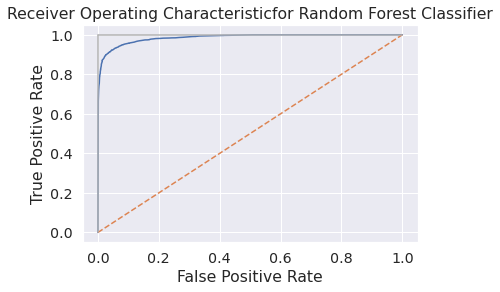

In [76]:
# Create true and false positive rates for ramdom forest
classes_hat = classifier.predict_proba(features_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(classes_test,
                                                               classes_hat)
# Plot ROC curve
#metrics.plot_roc_curve(classifier,false_positive_rate.reshape(-1,1), true_positive_rate.reshape(-1,1)) 

plt.title("Receiver Operating Characteristicfor Random Forest Classifier")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

#plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


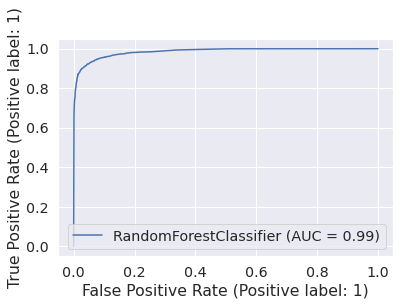

In [87]:
metrics.plot_roc_curve(classifier,features_test, classes_test)

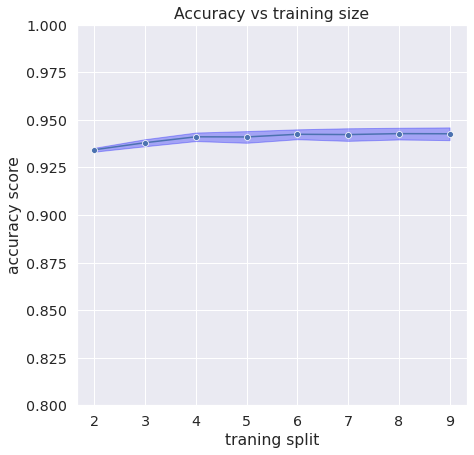

In [49]:
cvs = np.arange(2,10,1)
scores_array = []
scores_std_array = []
for i in cvs:
    scores = model_selection.cross_val_score(classifier, learn_data,
                                         classes, cv = i, scoring='accuracy')
    scores_array.append(scores.mean())
    scores_std_array.append(scores.std())

sa = np.array( scores_array) 
sa_std = np.array( scores_std_array) 
fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.3)
sns.axes_style("darkgrid")
ax = sns.lineplot(x =cvs, y= sa, marker='o')

# Plot accurancy bands for training and test sets
ax.fill_between(cvs, sa - sa_std,
                 sa + sa_std, color="blue",  alpha=0.3)

ax.set_title('Accuracy vs training size')
ax.set_xlabel('traning split')
ax.set_ylabel('accuracy score')
ax.set_ylim(0.8,1)
plt.show()

In [50]:
# Recursively eliminate features
rfecv = RFECV(estimator=classifier, step=1, scoring="accuracy")
rfecv.fit(learn_data, classes)
rfecv.transform(learn_data)

array([[1011792,      10,       3, ...,       1,       0,       0],
       [      0,      14,       2, ...,       0,     512,     112],
       [  56558,      10,       4, ...,       0,  124928,  124550],
       ...,
       [   4424,       1,       6, ...,       0,    1188,    1188],
       [  14211,       8,       5, ...,       0,   25088,   25084],
       [ 759185,       8,       4, ...,       0, 1024000, 1023703]])

In [51]:
# Number of best features
rfecv.n_features_

30

In [52]:
# Which categories are best
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True])

In [53]:
# Rank features best (1) to worst
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1])

In [68]:
# Standardize the feature matrix
#features = StandardScaler().fit_transform(learn_data)

# Create a PCA that will retain 99% of variance
pca = PCA(n_components=0.99, whiten=True)

# Conduct PCA
#features_pca = pca.fit_transform(features)
features_pca = pca.fit_transform(learn_data)

# Show results
print("Original number of features:", features.shape[1])
print("Reduced number of features:", features_pca.shape[1])

Original number of features: 31
Reduced number of features: 8


In [69]:
features_train_pca, features_test_pca, classes_train, classes_test = \
model_selection.train_test_split(features_pca, classes, test_size=0.2)

classifier2 = ensemble.RandomForestClassifier()
classifier2.fit(features_train_pca, classes_train)

prediction2 = classifier2.predict(features_test_pca)
print(metrics.accuracy_score(classes_test, prediction2))
print(metrics.confusion_matrix(classes_test, prediction2))
print(classification_report(classes_test, prediction2))
tn, fp, fn, tp =metrics.confusion_matrix(classes_test, prediction2).ravel()
fp_rate = fp/(fp +tn)
print('False Positive rate (FPR) = %.3f' % fp_rate)

0.9255014326647565
[[3450  237]
 [ 335 3656]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3687
           1       0.94      0.92      0.93      3991

    accuracy                           0.93      7678
   macro avg       0.93      0.93      0.93      7678
weighted avg       0.93      0.93      0.93      7678

False Positive rate (FPR) = 0.064
